# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
MAIN_DIR = '/content/drive/MyDrive/ibm_data'

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns

import random

In [ ]:
#!pip install pickle5 &> /dev/null
#import pickle5 as pickle

In [ ]:
train_data = pd.read_csv(os.path.join(MAIN_DIR, 'fruits_metadata.csv'))
display(train_data.head())

,fruit,path
0,APPLES,APPLES/0_100.jpg
1,APPLES,APPLES/100_100.jpg
2,APPLES,APPLES/101_100.jpg
3,APPLES,APPLES/102_100.jpg
4,APPLES,APPLES/103_100.jpg


In [ ]:
train_data['fruit'].unique()

array(['APPLES', 'BANANA', 'ORANGE', 'PINEAPPLE', 'WATERMELON'],
      dtype=object)

In [ ]:
def encoder(row):
  if row == 'APPLES':
    row = 0
  elif row == 'BANANA':
    row = 1
  elif row == 'ORANGE':
    row = 2
  elif row == 'PINEAPPLE':
    row = 3
  else:
    row = 4
  return row

train_data['label'] = train_data['fruit'].apply(encoder)

In [ ]:
def get_path(image_id):
    """adding the main path with the image paths"""
    
    return "/content/drive/MyDrive/ibm_data/TRAIN_SET/{}".format(image_id)

In [ ]:
train_data['path'] = train_data['path'].apply(get_path)

# Directory

In [ ]:
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Config

In [ ]:
# ====================================================
# CFG
# ====================================================
class CFG: #the configuration where all parameters/hyperparameters are stored
    debug=False
    apex=False
    print_freq=100
    num_workers=4
    model_name='tf_efficientnet_b0_ns'
    size=256
    scheduler='CosineAnnealingWarmRestarts' 
    criterion='CrossEntropyLoss' 
    epochs=2
    T_0=10 
    lr=1e-4
    min_lr=1e-6
    batch_size=32
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size = 5
    target_col = 'label'
    n_fold=5
    trn_fold = [0, 1, 2, 3, 4]
    train=True
    smoothing=0.05
    
if CFG.debug:
    CFG.epochs = 1
    train_data = train_data.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [ ]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('/content/drive/MyDrive/ibm_data/pytorch-image-models')

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

if CFG.apex:
    from torch.cuda.amp import autocast, GradScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utils

In [ ]:
def get_score(y_true, y_pred):
    """ function to calculate accuracy"""
    
    return accuracy_score(y_true, y_pred)

def init_logger(log_file=OUTPUT_DIR+'train.log'):
    """for logging the training steps"""
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed = 42):
    """to maintain reproducability"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed = CFG.seed)

# CV Split

In [ ]:
# making a 5 fold split
folds = train_data.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  label
0     0        122
      1         89
      2         95
      3        125
      4         95
1     0        121
      1         89
      2         96
      3        124
      4         95
2     0        121
      1         89
      2         96
      3        124
      4         95
3     0        121
      1         89
      2         96
      3        124
      4         95
4     0        121
      1         89
      2         96
      3        124
      4         95
dtype: int64


# Dataset

In [ ]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['path'].values
        self.labels = df[CFG.target_col].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label

(100, 100, 3)


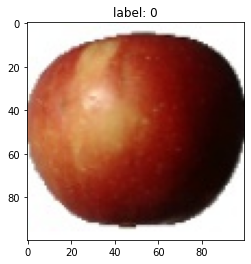

(100, 100, 3)


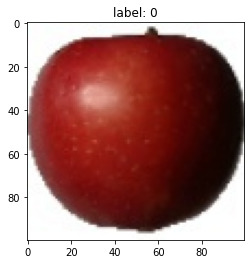

(100, 100, 3)


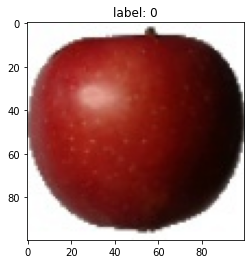

(100, 100, 3)


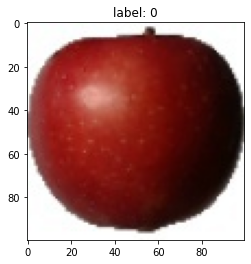

(100, 100, 3)


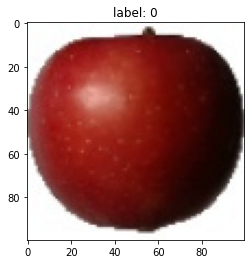

In [ ]:
train_dataset = TrainDataset(train_data, transform=None)

for i in range(5):
    image, label = train_dataset[i]
    print(image.shape)
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show()

# Transforms

In [ ]:
# all the augmentations are defined here here
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.RandomResizedCrop(CFG.size, CFG.size),
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

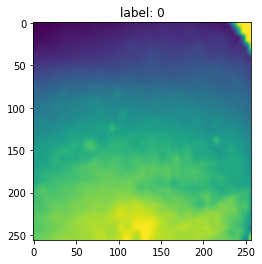

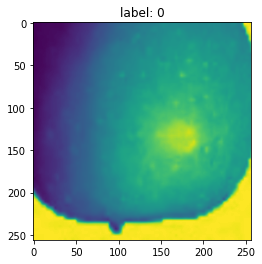

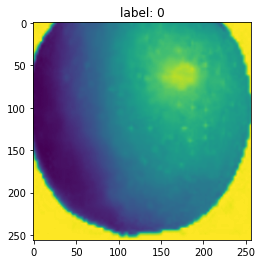

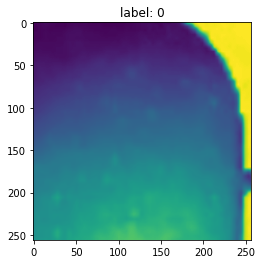

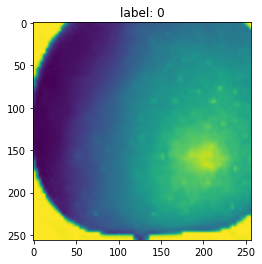

In [ ]:
train_dataset = TrainDataset(train_data, transform=get_transforms(data='train'))

for i in range(5):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show()

# Model

In [ ]:
# ====================================================
# MODEL 
# ====================================================
class CustomEfficientNet(nn.Module):
    """ using the efficientnet arch and modifying the final classification head"""
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(CFG.model_name, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
## for debug only
model = CustomEfficientNet(model_name=CFG.model_name, pretrained=False)
train_dataset = TrainDataset(train_data, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 3.6885e-02,  8.5828e-02,  9.2741e-02,  2.1368e-01, -4.4491e-01],
        [-8.7685e-02, -1.0964e-01,  6.5145e-02,  9.0393e-02,  1.0179e-02],
        [-1.1202e-01, -1.6264e-02,  5.9678e-03,  2.7062e-02,  2.2634e-04],
        [-1.2348e-01, -1.0647e-01,  5.4219e-02, -2.9790e-02, -2.3000e-02]],
       grad_fn=<AddmmBackward0>)


# Helper Functions

In [ ]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    """ convert to minutes"""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    """keep a tarck of time"""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    """the main train function is defined here, gradient clipping is done and final loss average is returned"""
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    """ the validation fucntion that returns the average validation loss and the prediction probability for each class(through softmax)"""
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

# Train Loop

In [ ]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        """ function that gets the scheduler"""
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================

    model = CustomEfficientNet(CFG.model_name, pretrained=True)
    
    model.to(device) #move to gpu if available

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)
        
    
    def get_criterion():
        """ get the loss function """
        if CFG.criterion=='CrossEntropyLoss':
            criterion = nn.CrossEntropyLoss()
        elif CFG.criterion=='LabelSmoothing':
            criterion = LabelSmoothingLoss(classes=CFG.target_size, smoothing=CFG.smoothing)
        return criterion


    # ====================================================
    # loop 
    # ====================================================
    criterion = get_criterion()
    LOGGER.info(f'Criterion: {criterion}')

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values
        
        if isinstance(scheduler, ReduceLROnPlateau): 
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1)) #use the argmax to get the highest index label and calculate accuracy

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')

        if score > best_score: #if the curr score is better than previous best, save and replace the best score
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds

In [ ]:
# ====================================================
# main
# ====================================================
def main():
    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    if CFG.train: #also making an out of fold dataframe for every prediction we make
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

In [ ]:
if __name__ == '__main__': #The entry point for the program to run
    main()

========== fold: 0 training ==========
INFO:__main__:========== fold: 0 training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_ns-c0e6a31c.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_ns-c0e6a31c.pth
Criterion: CrossEntropyLoss()
INFO:__main__:Criterion: CrossEntropyLoss()


Epoch: [1][0/65] Data 14.182 (14.182) Elapsed 0m 21s (remain 23m 20s) Loss: 1.5587(1.5587) Grad: 2.1206  
Epoch: [1][64/65] Data 13.430 (3.503) Elapsed 4m 10s (remain 0m 0s) Loss: 0.1789(0.7073) Grad: 1.0743  
EVAL: [0/17] Data 13.731 (13.731) Elapsed 0m 13s (remain 3m 40s) Loss: 0.0570(0.0570) 


Epoch 1 - avg_train_loss: 0.7073  avg_val_loss: 0.0500  time: 315s
INFO:__main__:Epoch 1 - avg_train_loss: 0.7073  avg_val_loss: 0.0500  time: 315s
Epoch 1 - Accuracy: 1.0
INFO:__main__:Epoch 1 - Accuracy: 1.0
Epoch 1 - Save Best Score: 1.0000 Model
INFO:__main__:Epoch 1 - Save Best Score: 1.0000 Model


EVAL: [16/17] Data 4.179 (3.711) Elapsed 1m 4s (remain 0m 0s) Loss: 0.0311(0.0500) 
Epoch: [2][0/65] Data 0.647 (0.647) Elapsed 0m 0s (remain 1m 1s) Loss: 0.0823(0.0823) Grad: 0.5457  
Epoch: [2][64/65] Data 0.000 (0.011) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0298(0.0603) Grad: 0.2402  
EVAL: [0/17] Data 0.611 (0.611) Elapsed 0m 0s (remain 0m 12s) Loss: 0.0118(0.0118) 


Epoch 2 - avg_train_loss: 0.0603  avg_val_loss: 0.0109  time: 18s
INFO:__main__:Epoch 2 - avg_train_loss: 0.0603  avg_val_loss: 0.0109  time: 18s
Epoch 2 - Accuracy: 1.0
INFO:__main__:Epoch 2 - Accuracy: 1.0
========== fold: 0 result ==========
INFO:__main__:========== fold: 0 result ==========
Score: 1.00000
INFO:__main__:Score: 1.00000
========== fold: 1 training ==========
INFO:__main__:========== fold: 1 training ==========


EVAL: [16/17] Data 0.000 (0.063) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0127(0.0109) 


Criterion: CrossEntropyLoss()
INFO:__main__:Criterion: CrossEntropyLoss()


Epoch: [1][0/65] Data 0.762 (0.762) Elapsed 0m 1s (remain 1m 13s) Loss: 1.6145(1.6145) Grad: 1.7917  
Epoch: [1][64/65] Data 0.000 (0.012) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0714(0.6911) Grad: 0.4603  
EVAL: [0/17] Data 0.665 (0.665) Elapsed 0m 0s (remain 0m 12s) Loss: 0.0399(0.0399) 


Epoch 1 - avg_train_loss: 0.6911  avg_val_loss: 0.0496  time: 18s
INFO:__main__:Epoch 1 - avg_train_loss: 0.6911  avg_val_loss: 0.0496  time: 18s
Epoch 1 - Accuracy: 1.0
INFO:__main__:Epoch 1 - Accuracy: 1.0
Epoch 1 - Save Best Score: 1.0000 Model
INFO:__main__:Epoch 1 - Save Best Score: 1.0000 Model


EVAL: [16/17] Data 0.000 (0.070) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0567(0.0496) 
Epoch: [2][0/65] Data 0.805 (0.805) Elapsed 0m 1s (remain 1m 17s) Loss: 0.0924(0.0924) Grad: 0.6852  
Epoch: [2][64/65] Data 0.000 (0.014) Elapsed 0m 17s (remain 0m 0s) Loss: 0.0086(0.0582) Grad: 0.0931  
EVAL: [0/17] Data 0.618 (0.618) Elapsed 0m 0s (remain 0m 11s) Loss: 0.0060(0.0060) 


Epoch 2 - avg_train_loss: 0.0582  avg_val_loss: 0.0083  time: 20s
INFO:__main__:Epoch 2 - avg_train_loss: 0.0582  avg_val_loss: 0.0083  time: 20s
Epoch 2 - Accuracy: 1.0
INFO:__main__:Epoch 2 - Accuracy: 1.0
========== fold: 1 result ==========
INFO:__main__:========== fold: 1 result ==========
Score: 1.00000
INFO:__main__:Score: 1.00000
========== fold: 2 training ==========
INFO:__main__:========== fold: 2 training ==========


EVAL: [16/17] Data 0.000 (0.063) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0075(0.0083) 


Criterion: CrossEntropyLoss()
INFO:__main__:Criterion: CrossEntropyLoss()


Epoch: [1][0/65] Data 0.796 (0.796) Elapsed 0m 1s (remain 1m 10s) Loss: 1.6122(1.6122) Grad: 1.9126  
Epoch: [1][64/65] Data 0.000 (0.013) Elapsed 0m 15s (remain 0m 0s) Loss: 0.2436(0.7003) Grad: 1.7077  
EVAL: [0/17] Data 0.715 (0.715) Elapsed 0m 0s (remain 0m 12s) Loss: 0.0723(0.0723) 


Epoch 1 - avg_train_loss: 0.7003  avg_val_loss: 0.0527  time: 19s
INFO:__main__:Epoch 1 - avg_train_loss: 0.7003  avg_val_loss: 0.0527  time: 19s
Epoch 1 - Accuracy: 1.0
INFO:__main__:Epoch 1 - Accuracy: 1.0
Epoch 1 - Save Best Score: 1.0000 Model
INFO:__main__:Epoch 1 - Save Best Score: 1.0000 Model


EVAL: [16/17] Data 0.000 (0.079) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0294(0.0527) 
Epoch: [2][0/65] Data 0.685 (0.685) Elapsed 0m 1s (remain 1m 7s) Loss: 0.0821(0.0821) Grad: 0.6543  
Epoch: [2][64/65] Data 0.000 (0.011) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0147(0.0603) Grad: 0.1595  
EVAL: [0/17] Data 0.662 (0.662) Elapsed 0m 0s (remain 0m 12s) Loss: 0.0074(0.0074) 


Epoch 2 - avg_train_loss: 0.0603  avg_val_loss: 0.0093  time: 19s
INFO:__main__:Epoch 2 - avg_train_loss: 0.0603  avg_val_loss: 0.0093  time: 19s
Epoch 2 - Accuracy: 1.0
INFO:__main__:Epoch 2 - Accuracy: 1.0


EVAL: [16/17] Data 0.000 (0.082) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0094(0.0093) 


========== fold: 2 result ==========
INFO:__main__:========== fold: 2 result ==========
Score: 1.00000
INFO:__main__:Score: 1.00000
========== fold: 3 training ==========
INFO:__main__:========== fold: 3 training ==========
Criterion: CrossEntropyLoss()
INFO:__main__:Criterion: CrossEntropyLoss()


Epoch: [1][0/65] Data 0.755 (0.755) Elapsed 0m 1s (remain 1m 9s) Loss: 1.6671(1.6671) Grad: 1.9966  
Epoch: [1][64/65] Data 0.000 (0.014) Elapsed 0m 17s (remain 0m 0s) Loss: 0.1541(0.7156) Grad: 0.7423  
EVAL: [0/17] Data 0.686 (0.686) Elapsed 0m 0s (remain 0m 12s) Loss: 0.0389(0.0389) 


Epoch 1 - avg_train_loss: 0.7156  avg_val_loss: 0.0599  time: 20s
INFO:__main__:Epoch 1 - avg_train_loss: 0.7156  avg_val_loss: 0.0599  time: 20s
Epoch 1 - Accuracy: 1.0
INFO:__main__:Epoch 1 - Accuracy: 1.0
Epoch 1 - Save Best Score: 1.0000 Model
INFO:__main__:Epoch 1 - Save Best Score: 1.0000 Model


EVAL: [16/17] Data 0.000 (0.080) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0416(0.0599) 
Epoch: [2][0/65] Data 0.775 (0.775) Elapsed 0m 1s (remain 1m 7s) Loss: 0.1483(0.1483) Grad: 0.9207  
Epoch: [2][64/65] Data 0.000 (0.012) Elapsed 0m 16s (remain 0m 0s) Loss: 0.0129(0.0681) Grad: 0.1148  
EVAL: [0/17] Data 0.694 (0.694) Elapsed 0m 0s (remain 0m 12s) Loss: 0.0104(0.0104) 


Epoch 2 - avg_train_loss: 0.0681  avg_val_loss: 0.0133  time: 19s
INFO:__main__:Epoch 2 - avg_train_loss: 0.0681  avg_val_loss: 0.0133  time: 19s
Epoch 2 - Accuracy: 1.0
INFO:__main__:Epoch 2 - Accuracy: 1.0
========== fold: 3 result ==========
INFO:__main__:========== fold: 3 result ==========
Score: 1.00000
INFO:__main__:Score: 1.00000
========== fold: 4 training ==========


EVAL: [16/17] Data 0.000 (0.080) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0209(0.0133) 


INFO:__main__:========== fold: 4 training ==========
Criterion: CrossEntropyLoss()
INFO:__main__:Criterion: CrossEntropyLoss()


Epoch: [1][0/65] Data 0.807 (0.807) Elapsed 0m 1s (remain 1m 9s) Loss: 1.6251(1.6251) Grad: 1.8545  
Epoch: [1][64/65] Data 0.000 (0.013) Elapsed 0m 16s (remain 0m 0s) Loss: 0.0982(0.6990) Grad: 0.7829  
EVAL: [0/17] Data 0.553 (0.553) Elapsed 0m 0s (remain 0m 10s) Loss: 0.0357(0.0357) 


Epoch 1 - avg_train_loss: 0.6990  avg_val_loss: 0.0446  time: 19s
INFO:__main__:Epoch 1 - avg_train_loss: 0.6990  avg_val_loss: 0.0446  time: 19s
Epoch 1 - Accuracy: 1.0
INFO:__main__:Epoch 1 - Accuracy: 1.0
Epoch 1 - Save Best Score: 1.0000 Model
INFO:__main__:Epoch 1 - Save Best Score: 1.0000 Model


EVAL: [16/17] Data 0.000 (0.078) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0350(0.0446) 
Epoch: [2][0/65] Data 0.855 (0.855) Elapsed 0m 1s (remain 1m 14s) Loss: 0.1906(0.1906) Grad: 1.0041  
Epoch: [2][64/65] Data 0.000 (0.015) Elapsed 0m 17s (remain 0m 0s) Loss: 0.0096(0.0530) Grad: 0.0955  
EVAL: [0/17] Data 0.558 (0.558) Elapsed 0m 0s (remain 0m 10s) Loss: 0.0049(0.0049) 


Epoch 2 - avg_train_loss: 0.0530  avg_val_loss: 0.0103  time: 20s
INFO:__main__:Epoch 2 - avg_train_loss: 0.0530  avg_val_loss: 0.0103  time: 20s
Epoch 2 - Accuracy: 1.0
INFO:__main__:Epoch 2 - Accuracy: 1.0
========== fold: 4 result ==========
INFO:__main__:========== fold: 4 result ==========
Score: 1.00000
INFO:__main__:Score: 1.00000


EVAL: [16/17] Data 0.000 (0.076) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0152(0.0103) 


========== CV ==========
INFO:__main__:========== CV ==========
Score: 1.00000
INFO:__main__:Score: 1.00000


In [ ]:
oof_df = pd.read_csv('./oof_df.csv')
oof_df

,fruit,path,label,fold,preds
0,APPLES,/content/drive/MyDrive/ibm_data/TRAIN_SET/APPL...,0,0,0
1,APPLES,/content/drive/MyDrive/ibm_data/TRAIN_SET/APPL...,0,0,0
2,APPLES,/content/drive/MyDrive/ibm_data/TRAIN_SET/APPL...,0,0,0
3,APPLES,/content/drive/MyDrive/ibm_data/TRAIN_SET/APPL...,0,0,0
4,APPLES,/content/drive/MyDrive/ibm_data/TRAIN_SET/APPL...,0,0,0
...,...,...,...,...,...
2621,WATERMELON,/content/drive/MyDrive/ibm_data/TRAIN_SET/WATE...,4,4,4
2622,WATERMELON,/content/drive/MyDrive/ibm_data/TRAIN_SET/WATE...,4,4,4
2623,WATERMELON,/content/drive/MyDrive/ibm_data/TRAIN_SET/WATE...,4,4,4
2624,WATERMELON,/content/drive/MyDrive/ibm_data/TRAIN_SET/WATE...,4,4,4


## Infer Script

In [ ]:
test_data = pd.read_csv(os.path.join(MAIN_DIR, 'fruits_metadata_test.csv'))
display(test_data.head())

def get_path(image_id):
    """adding the main path with the image paths"""
    
    return "/content/drive/MyDrive/ibm_data/TEST_SET/{}".format(image_id)

test_data['path'] = test_data['path'].apply(get_path)

,fruit,path
0,APPLES,APPLES/151_100.jpg
1,APPLES,APPLES/152_100.jpg
2,APPLES,APPLES/153_100.jpg
3,APPLES,APPLES/154_100.jpg
4,APPLES,APPLES/155_100.jpg


In [ ]:
test_data.shape

(1055, 2)

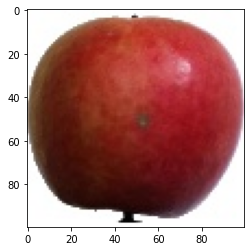

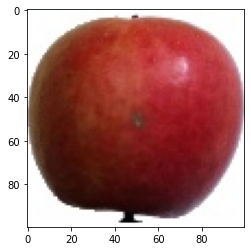

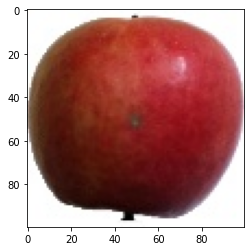

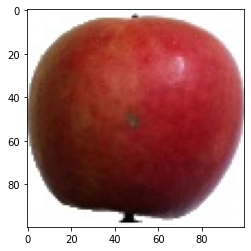

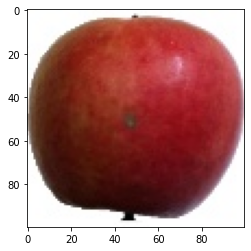

In [ ]:
# ====================================================
# Dataset
# ====================================================
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['path'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image

test_dataset = TestDataset(test_data, transform=None)

for i in range(5):
    image = test_dataset[i]
    plt.imshow(image)
    plt.show()

In [ ]:
# ====================================================
# Helper functions
# ====================================================
def load_state(model_path):
    """loading the state of model dictionary"""
    model = CustomEfficientNet(CFG.model_name, pretrained=False)
    model.load_state_dict(torch.load(model_path)['model'], strict=True)
    state_dict = torch.load(model_path)['model']
    return state_dict

def inference(model, states, test_loader, device):
    """making predictions on the test set"""
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state)
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
                #print(f'ypreds is : {y_preds}')
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
            #print(f'avgpreds is : {avg_preds}')
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

In [ ]:
# ====================================================
# inference
# ====================================================
model = CustomEfficientNet(CFG.model_name, pretrained=False)
MODEL_DIR = '/content/'
states = [load_state(MODEL_DIR+f'{CFG.model_name}_fold{fold}_best.pth') for fold in CFG.trn_fold]
test_dataset = TestDataset(test_data, transform=get_transforms(data='valid'))
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, 
                         num_workers=CFG.num_workers, pin_memory=True)
predictions = inference(model, states, test_loader, device)

test_data['model_preds'] = predictions.argmax(1) #argmax returns the highest index(class label)
test_data.head()

  0%|          | 0/33 [00:00<?, ?it/s]

,fruit,path,model_preds
0,APPLES,/content/drive/MyDrive/ibm_data/TEST_SET/APPLE...,0
1,APPLES,/content/drive/MyDrive/ibm_data/TEST_SET/APPLE...,0
2,APPLES,/content/drive/MyDrive/ibm_data/TEST_SET/APPLE...,0
3,APPLES,/content/drive/MyDrive/ibm_data/TEST_SET/APPLE...,0
4,APPLES,/content/drive/MyDrive/ibm_data/TEST_SET/APPLE...,0


In [ ]:
test_data['label'] = test_data['fruit'].apply(encoder)
test_data.sample(5)

,fruit,path,model_preds,label
260,BANANA,/content/drive/MyDrive/ibm_data/TEST_SET/BANAN...,1,1
832,PINEAPPLE,/content/drive/MyDrive/ibm_data/TEST_SET/PINEA...,3,3
846,PINEAPPLE,/content/drive/MyDrive/ibm_data/TEST_SET/PINEA...,3,3
1006,WATERMELON,/content/drive/MyDrive/ibm_data/TEST_SET/WATER...,4,4
88,APPLES,/content/drive/MyDrive/ibm_data/TEST_SET/APPLE...,0,0


In [ ]:
final_test_accuracy = get_score(test_data['label'].values, test_data['model_preds'].values)
print(f'the final accuracy in the test set is {final_test_accuracy}')

the final accuracy in the test set is 1.0


In [ ]:
from sklearn import metrics

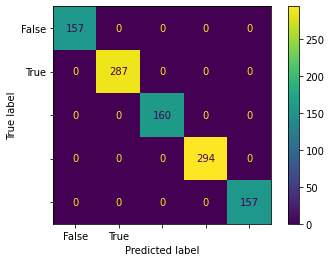

In [ ]:
confusion_matrix = metrics.confusion_matrix(test_data['label'].values, test_data['model_preds'].values)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
print(metrics.classification_report(test_data['label'].values, test_data['model_preds'].values))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       157
           1       1.00      1.00      1.00       287
           2       1.00      1.00      1.00       160
           3       1.00      1.00      1.00       294
           4       1.00      1.00      1.00       157

    accuracy                           1.00      1055
   macro avg       1.00      1.00      1.00      1055
weighted avg       1.00      1.00      1.00      1055



In [ ]:
print(f"the specificity is {metrics.recall_score(test_data['label'].values, test_data['model_preds'].values, pos_label=0,average = 'weighted')}")

the specificity is 1.0
